In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

In [2]:
cov_hosp = pd.read_csv("../data/COVID_hosp.csv")
cov_hosp = cov_hosp[cov_hosp['geography'] == 'DE']
cov_hosp = cov_hosp[['date', 'total']].rename(columns={'total': 'hosp'})
cov_hosp.set_index('date', inplace=True)
cov_hosp['hosp'] = cov_hosp['hosp'] / (84357 / 100) # normalized to 100k

In [3]:
# Read the Excel file into a DataFrame
cov_vir = pd.read_excel("../data/amelag_aggregierte_kurve.xlsx")
cov_vir = cov_vir[['datum', 'viruslast']].dropna()
cov_vir = cov_vir.rename(columns={'datum': 'date', 'viruslast': 'viral load'})
cov_vir['date'] = cov_vir['date'].dt.date.astype('str')
cov_vir['date'] = cov_vir['date'].replace(" 00:00:00", "")
cov_vir.set_index('date', inplace=True)

# Read the Excel file into a DataFrame
cov_vir_loess = pd.read_excel("../data/amelag_aggregierte_kurve.xlsx")
cov_vir_loess = cov_vir_loess[['datum', 'loess_vorhersage']].dropna()
cov_vir_loess = cov_vir_loess.rename(columns={'datum': 'date', 'loess_vorhersage': 'viral load (loess)'})
cov_vir_loess['date'] = cov_vir_loess['date'].dt.date.astype('str')
cov_vir_loess['date'] = cov_vir_loess['date'].replace(" 00:00:00", "")
cov_vir_loess.set_index('date', inplace=True)

In [4]:
# Combine dataframes based on index (date)
combined_df = pd.concat([cov_hosp, cov_vir, cov_vir_loess], axis=1)

# Export to Excel file
combined_df.to_excel("../data/combined_df.xlsx", index=True)

In [5]:
combined_df = combined_df[combined_df['viral load (loess)'].notna()]
combined_df = combined_df.rename(columns={'hosp': 'hospitalization incidence'})


In [6]:
combined_df.drop(columns="viral load",inplace=True)

In [7]:
combined_df.columns = ["hospitalization rate", "wastewater viral load (loess)"]

In [8]:
# Create a list of dates from 25.08.22 to 28.12.24 with a weekly frequency
date_list = pd.date_range(start='2022-08-18', end='2023-12-28', freq='7D').to_list()

72


In [9]:
metrics = pd.read_csv("../output/autoarima_False_metrics.csv")
metrics_ar = pd.read_csv("../output/autoarima_True_metrics.csv")

mapes = metrics
mapes_ar = metrics_ar
mapes.index = date_list
mapes_ar.index = date_list
mapes.columns = ["mape","mae"]
mapes_ar.columns = ["mape","mae"]

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels import api as sm
from scipy import stats

def combined_plot(time_series_df, mape_df, priority_columns=['wastewater viral load (loess)'], fontsize=16):
    # Normalize the time series data
    normalized_df = time_series_df.copy()
    for column in normalized_df.columns:
        max_value = normalized_df[column].max()
        normalized_df[column] = normalized_df[column] / max_value

    # Convert the indices of both dataframes to datetime if they are not already
    if not np.issubdtype(normalized_df.index.dtype, np.datetime64):
        normalized_df.index = pd.to_datetime(normalized_df.index)
    
    if not np.issubdtype(mape_df.index.dtype, np.datetime64):
        mape_df.index = pd.to_datetime(mape_df.index)
    
    # Sort both dataframes by index to ensure proper merging
    normalized_df = normalized_df.sort_index()
    mape_df = mape_df.sort_index()

    # Set the plot start date to one week before the first MAPE date
    plot_start_date = mape_df.index.min() - pd.Timedelta(weeks=1)
    normalized_df = normalized_df[normalized_df.index >= plot_start_date]

    # Merge time_series_df with mape_df by aligning on the nearest date
    merged_df = pd.merge_asof(normalized_df, mape_df, left_index=True, right_index=True, direction='backward')

    # Initialize the figure and plot the normalized time series data
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot normalized time series as lines
    for column in normalized_df.columns:
        if column not in priority_columns:
            ax1.plot(normalized_df.index, normalized_df[column], label=column, color="navy", zorder=1)
        else:
            ax1.plot(normalized_df.index, normalized_df[column], label=column, color="seagreen", zorder=2)

    # Adding labels and title for the primary y-axis
    ax1.set_xlabel('Date', fontsize=fontsize)
    ax1.set_ylabel('Normalized Value', fontsize=fontsize)
    ax1.set_title('Normalized Hospitalization Rate and Wastewater Viral Load and Model Performance MAPE over time', fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)

    # Format the x-axis to show months and rotate labels
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, fontsize=fontsize/1.5)

    # Adding legend for the primary y-axis
    ax1.legend(loc='upper left', fontsize=fontsize/1.5)

    # Plotting MAPE on the secondary y-axis
    ax2 = ax1.twinx()

    # Prepare the data for Quantile Regression
    df2 = merged_df[['mape']].dropna().copy()
    df2['date_ordinal'] = df2.index.to_series().apply(lambda x: x.toordinal())
    X = sm.add_constant(df2[['date_ordinal']])  # Adding a constant for intercept
    y = df2['mape']

    # Fit Quantile Regression
    quantile = 0.5  # Median (50th percentile)
    model = QuantReg(y, X)
    result = model.fit(q=quantile)
    y_pred = result.predict(X)

    # Calculate the confidence intervals
    n = len(X)
    alpha = 0.05  # 95% confidence interval
    t_value = stats.t.ppf(1 - alpha/2, n-2)

    residuals = y - y_pred
    se = np.sqrt(np.mean(residuals**2))
    s_y = np.sqrt(np.sum((residuals)**2) / (n - 2))
    confs = t_value * s_y * np.sqrt(1/n + (X['date_ordinal'] - np.mean(X['date_ordinal']))**2 / np.sum((X['date_ordinal'] - np.mean(X['date_ordinal']))**2))
 
    lower_bound = y_pred - confs
    upper_bound = y_pred + confs

    # Plot MAPE
    ax2.scatter(df2.index[::7], df2['mape'][::7], label='Test Window MAPE in %', color='tomato')
    
    # Plot the Quantile Regression line and confidence interval
    ax2.plot(df2.index, y_pred, color='salmon', label='Robust Regression Line ')
    ax2.fill_between(df2.index, lower_bound, upper_bound, color='b', alpha=0.1, label='95% Confidence Interval')
    for x in df2.index[::7]:
        ax2.axvline(x=x, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Adding legend for the secondary y-axis
    ax2.legend(loc='upper right', fontsize=fontsize/1.5)
    ax2.set_ylabel('Mean Absolute Percentage Error', fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)

    # Final adjustments and show plot
    fig.tight_layout()
    plt.savefig("../output/arima_mape_overtime.png")
    plt.show()


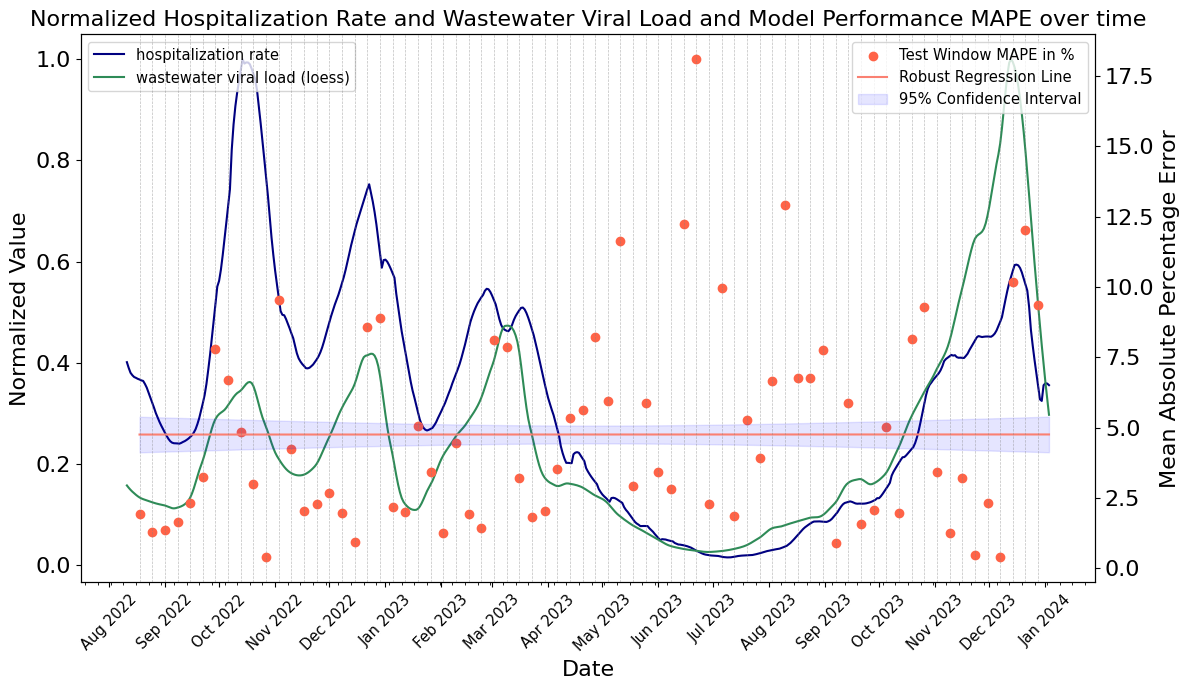

In [16]:
combined_plot(combined_df, mapes, priority_columns=['wastewater viral load (loess)'])

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels import api as sm
from scipy import stats

def combined_plot(time_series_df, mape_df, priority_columns=['wastewater viral load (loess)'], fontsize=16):
    # Normalize the time series data
    normalized_df = time_series_df.copy()
    for column in normalized_df.columns:
        max_value = normalized_df[column].max()
        normalized_df[column] = normalized_df[column] / max_value

    # Convert the indices of both dataframes to datetime if they are not already
    if not np.issubdtype(normalized_df.index.dtype, np.datetime64):
        normalized_df.index = pd.to_datetime(normalized_df.index)
    
    if not np.issubdtype(mape_df.index.dtype, np.datetime64):
        mape_df.index = pd.to_datetime(mape_df.index)
    
    # Sort both dataframes by index to ensure proper merging
    normalized_df = normalized_df.sort_index()
    mape_df = mape_df.sort_index()

    # Set the plot start date to one week before the first MAPE date
    plot_start_date = mape_df.index.min() - pd.Timedelta(weeks=1)
    normalized_df = normalized_df[normalized_df.index >= plot_start_date]

    # Merge time_series_df with mape_df by aligning on the nearest date
    merged_df = pd.merge_asof(normalized_df, mape_df, left_index=True, right_index=True, direction='backward')

    # Initialize the figure and plot the normalized time series data
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot normalized time series as lines
    for column in normalized_df.columns:
        if column not in priority_columns:
            ax1.plot(normalized_df.index, normalized_df[column], label=column, color="navy", zorder=1)
        else:
            ax1.plot(normalized_df.index, normalized_df[column], label=column, color="seagreen", zorder=2)

    # Adding labels and title for the primary y-axis
    ax1.set_xlabel('Date', fontsize=fontsize)
    ax1.set_ylabel('Normalized Value', fontsize=fontsize)
    ax1.set_title('Normalized Hospitalization Rate and Wastewater Viral Load and Model Performance MAE over time', fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)

    # Format the x-axis to show months and rotate labels
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, fontsize=fontsize/1)

    # Adding legend for the primary y-axis
    ax1.legend(loc='upper left', fontsize=fontsize/1.5)

    # Plotting MAE on the secondary y-axis
    ax2 = ax1.twinx()

    # Prepare the data for Quantile Regression
    df2 = merged_df[['mae']].dropna().copy()
    df2['date_ordinal'] = df2.index.to_series().apply(lambda x: x.toordinal())
    X = sm.add_constant(df2[['date_ordinal']])  # Adding a constant for intercept
    y = df2['mae']

    # Fit Quantile Regression
    quantile = 0.5  # Median (50th percentile)
    model = QuantReg(y, X)
    result = model.fit(q=quantile)
    y_pred = result.predict(X)

    # Calculate the confidence intervals
    n = len(X)
    alpha = 0.05  # 95% confidence interval
    t_value = stats.t.ppf(1 - alpha/2, n-2)

    residuals = y - y_pred
    se = np.sqrt(np.mean(residuals**2))
    s_y = np.sqrt(np.sum((residuals)**2) / (n - 2))
    confs = t_value * s_y * np.sqrt(1/n + (X['date_ordinal'] - np.mean(X['date_ordinal']))**2 / np.sum((X['date_ordinal'] - np.mean(X['date_ordinal']))**2))
 
    lower_bound = y_pred - confs
    upper_bound = y_pred + confs

    # Plot MAE
    ax2.scatter(df2.index[::7], df2['mae'][::7], label='Test Window MAE', color='tomato')
    
    # Plot the Quantile Regression line and confidence interval
    ax2.plot(df2.index, y_pred, color='salmon', label='Robust Regression Line ')
    ax2.fill_between(df2.index, lower_bound, upper_bound, color='b', alpha=0.1, label='95% Confidence Interval')
    for x in df2.index[::7]:
        ax2.axvline(x=x, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Adding legend for the secondary y-axis
    ax2.legend(loc='upper right', fontsize=fontsize/1.5)
    ax2.set_ylabel('Mean Absolute Error', fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)

    # Final adjustments and show plot
    fig.tight_layout()
    plt.savefig("../output/arima_mae_overtime.png")
    plt.show()


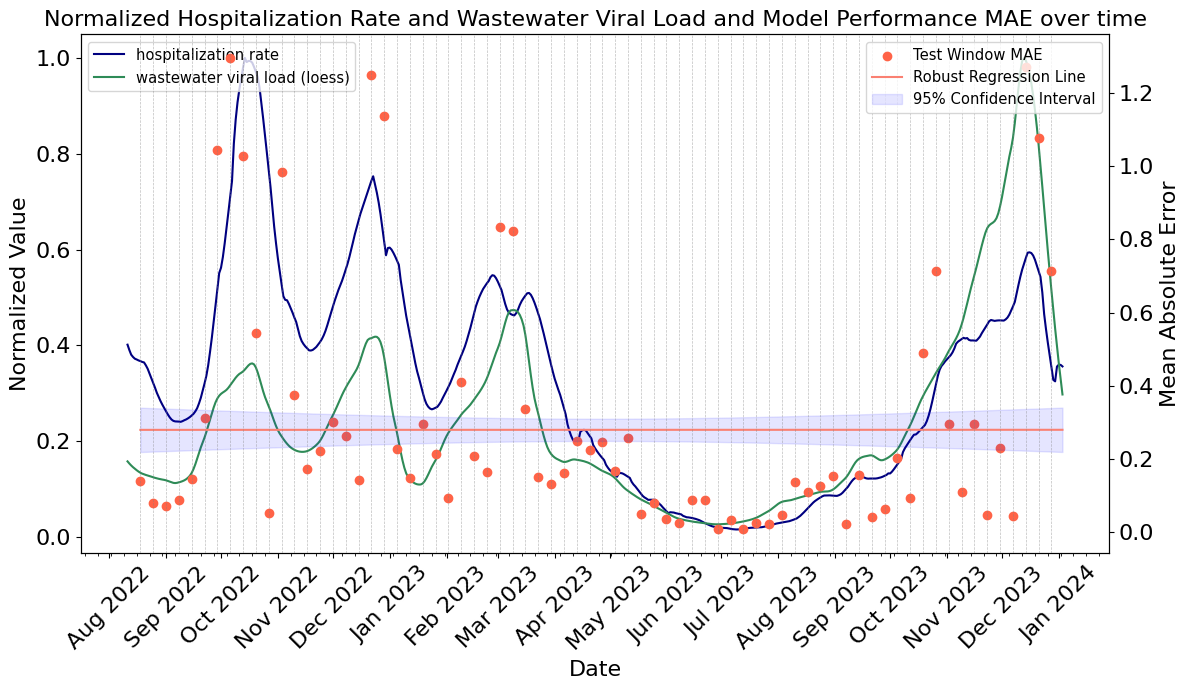

In [22]:
combined_plot(combined_df, mapes, priority_columns=['wastewater viral load (loess)'])

In [21]:
combined_df.columns = ["hospitalization rate", "wastewater viral load (loess)"]

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels import api as sm
from scipy import stats

def combined_plot(time_series_df, mape_df, priority_columns=['wastewater viral load (loess)']):
    # Normalize the time series data
    normalized_df = time_series_df.copy()
    for column in normalized_df.columns:
        max_value = normalized_df[column].max()
        normalized_df[column] = normalized_df[column] / max_value

    # Convert the indices of both dataframes to datetime if they are not already
    if not np.issubdtype(normalized_df.index.dtype, np.datetime64):
        normalized_df.index = pd.to_datetime(normalized_df.index)
    
    if not np.issubdtype(mape_df.index.dtype, np.datetime64):
        mape_df.index = pd.to_datetime(mape_df.index)
    
    # Sort both dataframes by index to ensure proper merging
    normalized_df = normalized_df.sort_index()
    mape_df = mape_df.sort_index()

    # Set the plot start date to one week before the first MAPE date
    plot_start_date = mape_df.index.min() - pd.Timedelta(weeks=1)
    normalized_df = normalized_df[normalized_df.index >= plot_start_date]

    # Merge time_series_df with mape_df by aligning on the nearest date
    merged_df = pd.merge_asof(normalized_df, mape_df, left_index=True, right_index=True, direction='backward')

    # Initialize the figure and plot the normalized time series data
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot normalized time series as lines
    for column in normalized_df.columns:
        if column not in priority_columns:
            ax1.plot(normalized_df.index, normalized_df[column], label=column, color="navy", zorder=1)
        else:
            ax1.plot(normalized_df.index, normalized_df[column], label=column, color="seagreen", zorder=2)

   # # Plot priority columns on top
   # for column in priority_columns:
    #    ax1.plot(normalized_df.index, normalized_df[column], label=column, zorder=2)

    # Adding labels and title for the primary y-axis
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Value')
    ax1.set_title('Normalized Hospitalization Rate and Wastewater Viral Load over time')
    ax1.tick_params(axis='y')

    # Format the x-axis to show months and rotate labels
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    # Adding legend for the primary y-axis
    ax1.legend(loc='upper center')

  
    # Final adjustments and show plot
    fig.tight_layout()
    plt.savefig("../output/normalized_ts.png")
    plt.show()
    


In [24]:
combined_df.dropna(inplace=True)


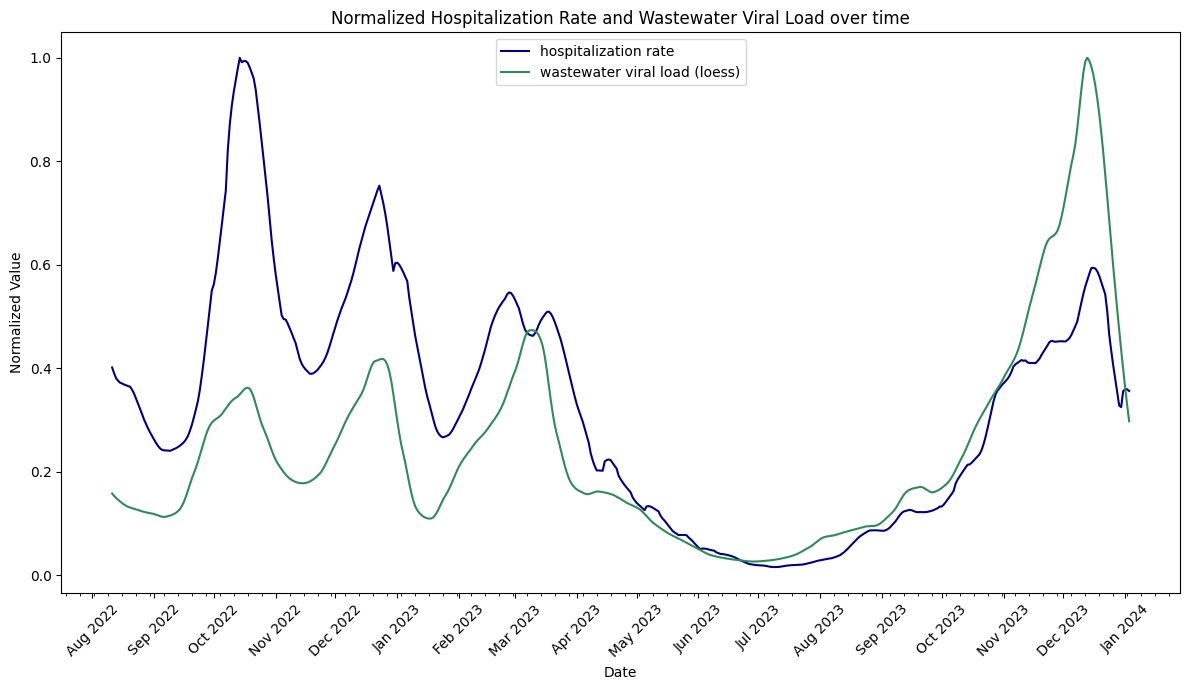

In [40]:
combined_plot(combined_df, mapes, priority_columns=['wastewater viral load (loess)'])